Mounted at /content/drive
XGBoost RMSE: 6.595306935835576
XGBoost MAE: 4.399785995483398
XGBoost R²: 0.9725155234336853


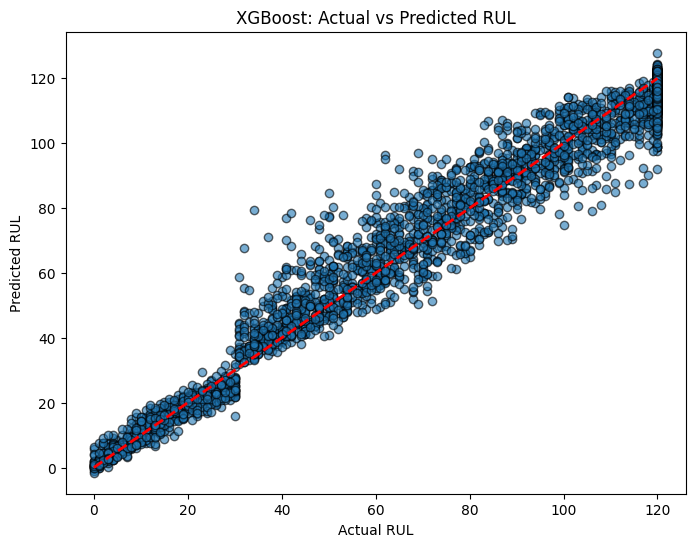

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 128)        │        87,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,561 (541.25 KB)

 Trainable params: 138,561 (541.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 34s 154ms/step - loss: 0.2151 - val_loss: 0.0341
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 32s 160ms/step - loss: 0.0457 - val_loss: 0.0287
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 30s 152ms/step - loss: 0.0331 - val_loss: 0.0199
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - loss: 0.0234 - val_loss: 0.0188
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - loss: 0.0202 - val_loss: 0.0164
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - loss: 0.0164 - val_loss: 0.0179
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 152ms/step - loss: 0.0144 - val_loss: 0.0175
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 30s 154ms/step - loss: 0.0128 - val_loss: 0.0210
Epoch 9/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 151ms/step - loss: 0.0111 - val_loss: 0.0189
Epoch 10/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 155ms/step - loss: 0.0094 - val_loss: 0.0184
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
LSTM RMSE: 15.381859646193885
LSTM MAE: 12.14735610758672
LSTM R²: 0.

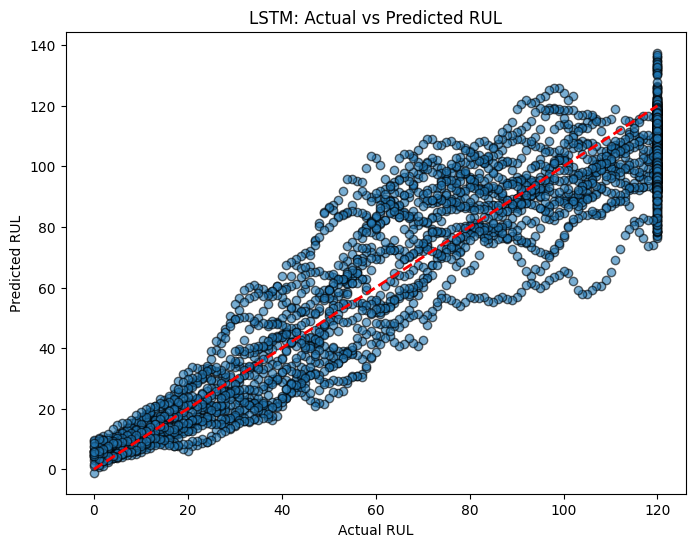

Processed data saved
Saved to: /content/drive/MyDrive/predictive_maintenance/processed_data_xgb_vs_lstm.csv


In [1]:
### -------------------------------------------------------------------- ###
# --- Baseline Models (XGBoost & LSTM)
### -------------------------------------------------------------------- ###

# 1. --- Imports ---
from google.colab import drive
drive.mount('/content/drive')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping   # importing this to avoid overfitting

# let Create results folder for saving plots in form of PNG
if not os.path.exists('../results'):
  os.makedirs('../results')
# --------------------------- #
# Load Data
file_path = '/content/drive/MyDrive/predictive_maintenance/processed_train_FD001.csv'
df = pd.read_csv(file_path)

# ------------------------------------------------- #
# --- 2. Add RUL (Remaining Useful Life) target ---
# ------------------------------------------------- #

# RUL = (max cycles for that engnine) - (current cycle)
# Clip at 120 to avoid extreme values
df['RUL'] = df.groupby('unit_number')['time_in_cycles'].transform(lambda x: x.max() - x)
df['RUL'] = df['RUL'].clip(upper=120)

# -------------------------------------------------- #
# --- 3. XGBoost Model(tabular prediction) ---
# -------------------------------------------------- #
X = df.drop(columns=['RUL'])
y = df['RUL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("XGBoost MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))

# ---------------------------------------------------------------- #
# --- 4. Visualize the plots for XGB : Actual vs Predicted RUL ---
# ---------------------------------------------------------------- #
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('XGBoost: Actual vs Predicted RUL')
plt.savefig('../results/actual_vs_pred_xgb.png', dpi=300)  # Save a plot as PNG and dpi for a good quality.
plt.show()

# ----------------------------------------------------------------- #
# --- 5. LSTM Model(time-series prediction) ---
# ----------------------------------------------------------------- #
def create_sequences(df, seq_length, features, target_col):
    X, y = [], [] # empty lists for target RUL
    for engine_id in df['unit_number'].unique():
        engine_data = df[df['unit_number'] == engine_id]   #this loop will generate sequences for each engine capturing temporal patterns
        feature_array = engine_data[features].values
        target_array = engine_data[target_col].values

        for i in range(len(feature_array) - seq_length + 1):
            X.append(feature_array[i:i+seq_length])
            y.append(target_array[i+seq_length-1])
    return np.array(X), np.array(y)

# Features
final_features = [col for col in df.columns if 'sensor_measurement' in col or 'op_setting' in col]

# --------------------------------------------------------------------------------- #
#  --- 6. Scale features FIRST (makes sure all features are in a similar range) ---
# --------------------------------------------------------------------------------- #
scaler = StandardScaler()
df[final_features] = scaler.fit_transform(df[final_features])

# ------------------------------------- #
# --- 7. Train/test split by engine ---
# ------------------------------------- #
train_engines, test_engines = train_test_split(df['unit_number'].unique(), test_size=0.2, random_state=42)
train_seq_df = df[df['unit_number'].isin(train_engines)]
test_seq_df = df[df['unit_number'].isin(test_engines)]

seq_length = 50 # Picking sequence length (captures temporal patterns)
X_train_seq, y_train_seq = create_sequences(train_seq_df, seq_length, final_features, 'RUL')
X_test_seq, y_test_seq   = create_sequences(test_seq_df, seq_length, final_features, 'RUL')

# Scale target (RUL)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_seq.reshape(-1,1))
y_test_scaled  = y_scaler.transform(y_test_seq.reshape(-1,1))

# -------------------------------- #
# --- 8. Build model ---
# -------------------------------- #
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(seq_length, len(final_features))),
    Dropout(0.3),      # (I am using Two-layer lstm with dropout to prevent overfitting and avoid losses occured for one layer)
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
model.summary()

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(                                 # this part in code stores training progress and helps track model performance
    X_train_seq, y_train_scaled,
    validation_data=(X_test_seq, y_test_scaled),
    epochs=50,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

# Predictions
y_pred_scaled = model.predict(X_test_seq)     # we scale these to bring RUL into the range [0,1], as predictions are also scaled.
y_pred_lstm = y_scaler.inverse_transform(y_pred_scaled)
y_test_true = y_scaler.inverse_transform(y_test_scaled)            # scale --> train --> predict --> inversecycle(this step to interpret predictions in real-world units)

# Metrics for LSTM
print("LSTM RMSE:", np.sqrt(mean_squared_error(y_test_true, y_pred_lstm)))
print("LSTM MAE:", mean_absolute_error(y_test_true, y_pred_lstm))
print("LSTM R²:", r2_score(y_test_true, y_pred_lstm))

# -------------------------------------------------- #
# --- 9. Plot for LSTM : Actual vs Predicted RUL ---
# -------------------------------------------------- #
plt.figure(figsize=(8,6))
plt.scatter(y_test_true, y_pred_lstm, alpha=0.6, edgecolors='k')
plt.plot([y_test_true.min(), y_test_true.max()],
         [y_test_true.min(), y_test_true.max()],
         'r--', lw=2)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('LSTM: Actual vs Predicted RUL')
plt.savefig('../results/actual_vs_pred_lstm.png', dpi=300)    # Save the plot of comparison in PNG format
plt.show()

# ----------------------------------------------------- #
# --- 10. Save the XGBoost & LSTM Model and processed Data
# ----------------------------------------------------- #
output_path = "/content/drive/MyDrive/predictive_maintenance/processed_data_xgb_vs_lstm.csv"

print("Processed data saved")
print(f"Saved to: {output_path}")

# Save as .pkl for xgboost model
joblib.dump(xgb_model, 'xgb_model.pkl')
loaded_xgb= joblib.load('xgb_model.pkl')

# Save the model as .h5 for lstm model
model.save('lstm_model.h5')
# ======================================================== #
# Summary

# In this part, we tried to train two baseline models to predict RUL: XGBoost for tabular and LSTM for time-series dsta.
# We scaled features and targets, split engines into train/test, and created sequences for LSTM to capture temporal trends.
# concluding this analysis we check model performance, visualized predictions, and saved the data for next analysis.

# ========================================================= #